In [60]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import psycopg2
import calendar
import random
import seaborn as sns
import numpy as np
import itertools
import warnings
warnings.filterwarnings("ignore")

In [61]:
# SoftTouch Lenses complete database
conn = psycopg2.connect(
host = "shopify-merchant-dump.ccm9mnr5avgs.ap-south-1.rds.amazonaws.com",
  user = "toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c",
  password = "toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c_password",
  database = "toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c_db",
  port = '5432'
)

# conn = psycopg2.connect(
# host = "shopify-merchant-dump.ccm9mnr5avgs.ap-south-1.rds.amazonaws.com",
#   user = "toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c",
#   password = "toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c_password",
#   database = "toffee_coffee_roasters_69e3f806d0674953afe3d3fb2f724c7c_db",
#   port = '5432'
# )

In [62]:
query1 = """select o.id as order_id,
            o.created_at::date as order_date,
            o.customer_id as user_id,
            oli.product_id as product_id,
            oli.name as product_name,
            o.total_price as order_amount,
            CASE
        WHEN cancelled_at IS NOT NULL THEN 'Cancelled'
         ELSE 'Delivered'
     END as order_status,
            oli.quantity as quantity,
            oli.price as sp
            from orders o
            join order_line_item oli on oli.order_id = o.id"""

In [63]:
data = pd.read_sql(query1, conn)

In [64]:
data["order_date"] = pd.to_datetime(data["order_date"])
data[data["product_id"] == np.nan]
data = data.dropna()
data['WeekCount']=data['order_date'].dt.strftime('%Y-w%U')
data=data.sort_values('order_date')
WeekList=data['WeekCount'].unique()
data = data[data['order_status'] != 'cancelled']

In [65]:
WeekList = WeekList.tolist()
output_list = []

for i in range(len(WeekList) - 1):
    output_list.append(WeekList[i])
    current_week = int(WeekList[i].split('-w')[1])
    next_week = int(WeekList[i + 1].split('-w')[1])
    missing_weeks = next_week - current_week - 1
    for j in range(1, missing_weeks + 1):
        missing_week = current_week + j
        output_list.append(f'{WeekList[i][:5]}w{missing_week:02d}')

output_list.append(WeekList[-1])

In [66]:
orderuserlevel=data.groupby(['order_id','user_id']).agg(
          order_date=pd.NamedAgg(column='order_date', aggfunc='min'),

    ).reset_index()
orderuserlevel=orderuserlevel.sort_values('order_date')
orderuserlevel['TrxnRank'] = orderuserlevel.groupby('user_id')['order_date'].rank(method='first')
orderuserlevel


data=pd.merge(data,
         orderuserlevel[['order_id','TrxnRank']],
         on="order_id",
         how ='left')
data['New']=0
data['Repeat']=0
data.loc[data['TrxnRank']==1,'New']=1
data.loc[data['TrxnRank']>1,'Repeat']=1

#AOV Contribution
data['ordervalue']=data['quantity']*data['sp']
data['AOVContribution']=data['ordervalue']/data["order_id"].nunique()
data['DeltaDaysinOrders']=(data.groupby('user_id').order_date.shift() - data.order_date).dt.days.abs()
data['DeltaOrderValues']=(data.groupby('user_id').ordervalue.shift() - data.ordervalue)

In [67]:
Weekly_Stats = {}
productsegstats_weekly = {}
user_cohort_labels = ['New Users', 'Churned Users', 'Recent & Loyal Users', 'Champion Users', 'Repeat Churned Users']
user_cohort_var_list = ['Users']#, 'Orders', 'Recency', 'AOVContribution', 'OrderValue','MeanDaysDelta', 'MeanOVDelta', 'Maturity', 'Frequency', 'AOV'
product_cohort_labels=['Hero Products', 'High Value & Slow Moving Products', 'Low Value & Slow Moving Products', 'New Business Products', 'High Repeat Products']
product_cohort_var_list=['ProductCount'] #'Orders','Users','AverageSellingPrice','QuantityperCart','CartPenetration','NewUserRatio','NewOrders','ASPXQpC','AOVContribution','ProductCountMix','OrdersMix','UsersMix','AOVContribution(%)','OrderPerSKU'
final_stats = pd.DataFrame()
# avg_delta_days = data["DeltaDaysinOrders"].mean()

for x in output_list:
  x3 = data[data['WeekCount'] <= x]
  try:
    userweeklydata = x3.groupby("user_id").agg(
          Last_Date=pd.NamedAgg(column='order_date', aggfunc= lambda x: np.min(np.sort(x)[-2:])),
          First_Date=pd.NamedAgg(column='order_date', aggfunc='min'),
          OrdersCount=pd.NamedAgg(column='order_id', aggfunc='nunique'),
          Frequency=pd.NamedAgg(column='order_id', aggfunc='nunique'),
          Order_Value=pd.NamedAgg(column='ordervalue', aggfunc='sum'),
          #Mean_Days_Delta=pd.NamedAgg(column='DeltaDaysinOrders', aggfunc='mean'),
          #Mean_OV_Delta=pd.NamedAgg(column='DeltaOrderValues', aggfunc='mean')
          ).reset_index()

    globalmaxdateweek=x3['order_date'].max()
    userweeklydata['Recency']=globalmaxdateweek-userweeklydata['Last_Date']
    userweeklydata['Recency']=userweeklydata['Recency'].dt.days.abs()
    userweeklydata['MaturityAge']=np.nan
    userweeklydata.loc[userweeklydata['Frequency']>1,"MaturityAge"]=(userweeklydata['Last_Date']-userweeklydata['First_Date']).dt.days.abs()
    #userweeklydata['Mean_Days_Delta']=userweeklydata['Mean_Days_Delta'].fillna(0)
    #userweeklydata['Mean_OV_Delta']=userweeklydata['Mean_OV_Delta'].fillna(0)
    userweeklydata['Customer_AOV']=userweeklydata['Order_Value']/userweeklydata['OrdersCount']

    r_labels, f_labels,AOV_labels, m_labels,DelAOV_labels = range(4, 0, -1), range(1,5), range(1,5),range(1,5),range(1,5)
    #userweeklydata['value_score'] = userweeklydata['Order_Value'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = f_labels)).astype('int64')
    userweeklydata['r_score'] = userweeklydata['Recency'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = r_labels)).astype('int64')
   # userweeklydata['AOV_score'] = userweeklydata['Customer_AOV'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = AOV_labels)).astype('int64')
    userweeklydata['m_score']=0
    userweeklydata.loc[userweeklydata['MaturityAge'].notnull(),'m_score']= userweeklydata.loc[userweeklydata['MaturityAge'].notnull()]['MaturityAge'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = m_labels)).astype('int64')
    #userweeklydata['DelAOV'] = userweeklydata['Mean_OV_Delta'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = DelAOV_labels)).astype('int64')
    #userweeklydata['SumScore'] = userweeklydata['r_score'] + userweeklydata['m_score'] + userweeklydata['AOV_score']+ userweeklydata['DelAOV'] +userweeklydata['f_score']
    def CohortLables_3(df):
      if ((df['Frequency']==1) & (df['r_score']>2)):
          return "New Users"
      elif ((df['Frequency'] == 1) & (df['r_score'] <= 2)):
          return 'Churned Users'

      elif ((df['Frequency'] > 1) & (df['m_score'] < 3) & (df['r_score'] >2)):
          return 'Recent & Loyal Users'
      elif ((df['Frequency'] > 1) & (df['m_score'] >=3) & (df['r_score'] > 2)):
          return 'Champion Users'
      else:
          return 'Repeat Churned Users'
    userweeklydata['User_Cohort_Label'] = userweeklydata.apply(CohortLables_3, axis=1)
    x3=pd.merge(x3,
         userweeklydata[['user_id','User_Cohort_Label']],
         on="user_id",
         how ='left')

    totalcarts=x3['order_id'].nunique()
    product_level=x3.groupby(['product_name']).agg(
            Carts=pd.NamedAgg(column='order_id', aggfunc='nunique'),
            Quantity=pd.NamedAgg(column='quantity', aggfunc='sum'),
            ASP=pd.NamedAgg(column='sp', aggfunc='mean'),
            NewOrders=pd.NamedAgg(column='New', aggfunc='sum'),
            RepeatOrders=pd.NamedAgg(column='Repeat', aggfunc='sum'),
            Users=pd.NamedAgg(column='user_id', aggfunc='nunique'),
            AOVContribution=pd.NamedAgg(column='AOVContribution', aggfunc='sum'),
    ).reset_index()
    produser=data.groupby(['product_name','user_id']).agg(
        New_user=pd.NamedAgg(column='user_id', aggfunc='nunique')
    ).reset_index()
    produser_newcount=produser.groupby('product_name').agg(
        New_count=pd.NamedAgg(column='New_user', aggfunc='sum')
    ).reset_index()
    data_repeat=data[data['TrxnRank']==2]
    produser_repeatcount=data_repeat.groupby('user_id').agg(
        Repeat_count=pd.NamedAgg(column='user_id', aggfunc='nunique')
    ).reset_index()
    k=pd.merge(produser,produser_repeatcount,on='user_id',how='left')
    k.fillna(0)
    k1=k.groupby('product_name').agg(
        Repeat_count=pd.NamedAgg(column='Repeat_count', aggfunc='sum')
    ).reset_index()
    productlevel=pd.merge(product_level,produser_newcount, on='product_name', how='left')
    productlevel=pd.merge(productlevel,k1,on='product_name',how='left')

    productlevel['NewRepeatConversionRatio']=productlevel['Repeat_count']/productlevel['New_count']
    productlevel=productlevel.sort_values('NewRepeatConversionRatio')
    productlevel['CartPenetration']=productlevel['Carts']/totalcarts
    productlevel['QpC']=productlevel['Quantity']/productlevel['Carts']
    productlevel['ASPXQpC']=productlevel['ASP']*productlevel['QpC']

    CP_labels, NewRatio_labels,ASP_labels, QpC_labels =  range(1,5), range(1,5),range(1,5),range(1,5)
    productlevel['CP_score'] = productlevel['CartPenetration'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = CP_labels)).astype('int64')
    productlevel['NewRepeatConversion_score'] = productlevel['NewRepeatConversionRatio'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = NewRatio_labels)).astype('int64')
    productlevel['ASP_score'] = productlevel['ASP'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = ASP_labels)).astype('int64')
    productlevel['QpC_score'] = productlevel['QpC'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = QpC_labels)).astype('int64')
    productlevel['SumScore'] = productlevel['CP_score'] + productlevel['NewRepeatConversion_score'] + productlevel['ASP_score'] + productlevel['QpC_score']
    def ProductCohortLables2(df):
        if ((df['CP_score']>2) and (df['NewRepeatConversion_score']>2)):
            return 'Hero Products'
        elif df['NewRepeatConversion_score'] >2:
            return 'High Repeat Products'
        elif (df['CP_score'] >2):
            return 'New Business Products'
        elif (df['ASP_score'] >3):
            return 'High Value & Slow Moving Products'
        elif (df['ASP_score'] <=3):
            return 'Low Value & Slow Moving Products'
        else:
            return 'Low Value & Slow Moving Products'
    productlevel['Product Cohort Lables'] = productlevel.apply(ProductCohortLables2, axis=1)

    x3=pd.merge(x3,
         productlevel[['product_name','Product Cohort Lables']],
         on="product_name",
         how ='left')


    User_Product_Level=x3.groupby(['User_Cohort_Label','Product Cohort Lables']).agg(
        Order_Value=pd.NamedAgg(column='ordervalue', aggfunc='sum'),
            Users=pd.NamedAgg(column='user_id', aggfunc='nunique'),
        Order_Count=pd.NamedAgg(column='order_id', aggfunc='nunique'),

    ).reset_index()

    Weekly_Stats[x] = User_Product_Level
    x4 = data[data['WeekCount']==x]
    x5 = pd.merge(x4,userweeklydata[['user_id','User_Cohort_Label']], on='user_id', how='left')
    x6 = pd.merge(x5,productlevel[['product_name','Product Cohort Lables']], on='product_name', how='left')
    final_stats = final_stats.append(x6, ignore_index=True)
    final_stats = pd.concat([final_stats, x5], ignore_index=True)

  except:
    pass

In [198]:
#AOV Contribution
final_stats['ordervalue']=final_stats['ordervalue']
final_stats['AOVContribution']=final_stats['ordervalue']/final_stats["order_id"].nunique()
final_stats['DeltaDaysinOrders']=(final_stats.groupby('user_id').order_date.shift() - final_stats.order_date).dt.days.abs()
final_stats['DeltaOrderValues']=(final_stats.groupby('user_id').ordervalue.shift() - final_stats.ordervalue)
weekly_summary_stats = final_stats.groupby(['WeekCount','User_Cohort_Label','Product Cohort Lables']).agg(
            totalorders=pd.NamedAgg(column='order_id', aggfunc='nunique'),
            totalusers=pd.NamedAgg(column='user_id', aggfunc='nunique'),
            totalvalue=pd.NamedAgg(column='ordervalue', aggfunc='sum'),
            quantity=pd.NamedAgg(column='quantity', aggfunc='sum'),
            SKUCounts=pd.NamedAgg(column='product_id', aggfunc='nunique')
      ).reset_index()
newdf=final_stats[final_stats['New']==1].groupby(['WeekCount','User_Cohort_Label','Product Cohort Lables']).agg(
    newusercount=pd.NamedAgg(column='user_id', aggfunc='nunique'),
     ).reset_index()
cancelled_orders = final_stats[final_stats['order_status'] == 'Cancelled'].groupby(['WeekCount','User_Cohort_Label','Product Cohort Lables']).agg(
    CancellationCount=pd.NamedAgg(column='order_id', aggfunc='count')
).fillna(0).reset_index()

delivered_orders = final_stats[final_stats['order_status'] == 'Delivered'].groupby(['WeekCount','User_Cohort_Label','Product Cohort Lables']).agg(
    DeliveryCount=pd.NamedAgg(column='order_id', aggfunc='count')
).fillna(0).reset_index()
weekly_summary_stats = weekly_summary_stats.merge(newdf, on=['WeekCount','User_Cohort_Label','Product Cohort Lables'], how="left")
weekly_summary_stats =weekly_summary_stats.merge(cancelled_orders, on=['WeekCount','User_Cohort_Label','Product Cohort Lables'], how="left")
weekly_summary_stats = weekly_summary_stats.merge(delivered_orders, on=['WeekCount','User_Cohort_Label','Product Cohort Lables'], how="left")
weekly_summary_stats['repeatusercount']=weekly_summary_stats['totalusers']-weekly_summary_stats['newusercount']
weekly_summary_stats['AOV'] = weekly_summary_stats['totalvalue']/ weekly_summary_stats['totalorders']


In [199]:
final_stats["Retention"] = 0
final_stats.loc[(final_stats["DeltaDaysinOrders"] > 0) & (final_stats["DeltaDaysinOrders"] <= 90) , "Retention"] = "Retained"
final_stats.loc[(final_stats["DeltaDaysinOrders"] > 90), "Retention"] = "Not-Retained"
retained_df = final_stats[final_stats['Retention'] == 'Retained'].groupby(['WeekCount','User_Cohort_Label','Product Cohort Lables']).size().reset_index(name='Retained_Users')
weekly_summary_stats = pd.merge(weekly_summary_stats, retained_df, on=['WeekCount','User_Cohort_Label','Product Cohort Lables'], how="left")
weekly_summary_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1956 entries, 0 to 1955
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   WeekCount              1956 non-null   object 
 1   User_Cohort_Label      1956 non-null   object 
 2   Product Cohort Lables  1956 non-null   object 
 3   totalorders            1956 non-null   int64  
 4   totalusers             1956 non-null   int64  
 5   totalvalue             1956 non-null   float64
 6   quantity               1956 non-null   int64  
 7   SKUCounts              1956 non-null   int64  
 8   newusercount           1022 non-null   float64
 9   CancellationCount      115 non-null    float64
 10  DeliveryCount          1953 non-null   float64
 11  repeatusercount        1022 non-null   float64
 12  AOV                    1956 non-null   float64
 13  Retained_Users         834 non-null    float64
dtypes: float64(7), int64(4), object(3)
memory usage: 229.2+ 

In [200]:
key_metrices = ['WeekCount','User_Cohort_Label','Product Cohort Lables','totalorders', 'totalvalue', 'repeatusercount','newusercount', 'AOV']
weekly_summary_stats = weekly_summary_stats[key_metrices]

weekly_summary_stats = weekly_summary_stats.rename(columns={
    'totalorders':'Total_Orders',
    'totalvalue': 'Total_Value',
    'repeatusercount': 'No_of_Repeat_Users',
    'newusercount': 'No_of_New_Users(First_Time_Users)',
    'AOV': 'Average_Order_Value'
})
weekly_summary_stats=weekly_summary_stats.fillna(0)

In [201]:
weekly_summary_stats["Product Cohort Lables"].unique()

array(['New Business Products', 'High Repeat Products', 'Hero Products',
       'Low Value & Slow Moving Products',
       'High Value & Slow Moving Products'], dtype=object)

In [202]:
weekly_summary_stats

,WeekCount,User_Cohort_Label,Product Cohort Lables,Total_Orders,Total_Value,No_of_Repeat_Users,No_of_New_Users(First_Time_Users),Average_Order_Value
0,2020-w38,Champion Users,New Business Products,25,16250.0,0.0,10.0,650.000000
1,2020-w38,Churned Users,High Repeat Products,1,585.0,0.0,1.0,585.000000
2,2020-w38,Churned Users,New Business Products,303,196820.0,0.0,303.0,649.570957
3,2020-w38,New Users,New Business Products,313,203385.0,0.0,313.0,649.792332
4,2020-w38,Recent & Loyal Users,New Business Products,33,21450.0,0.0,15.0,650.000000
...,...,...,...,...,...,...,...,...
1951,2023-w52,New Users,Hero Products,4,3640.0,0.0,4.0,910.000000
1952,2023-w52,New Users,New Business Products,71,22761.0,0.0,71.0,320.577465
1953,2023-w52,Recent & Loyal Users,Hero Products,2,1200.0,0.0,0.0,600.000000
1954,2023-w52,Recent & Loyal Users,New Business Products,30,8069.0,24.0,3.0,268.966667


In [203]:
weekly_summary_stats['Average_Order_Value'] = weekly_summary_stats['Total_Value'] / weekly_summary_stats.groupby('WeekCount')['Total_Orders'].transform('sum')

In [204]:
weekly_summary_stats["key"] = weekly_summary_stats["User_Cohort_Label"] + "<>" + weekly_summary_stats["Product Cohort Lables"] # change

In [205]:
weekly_summary_stats

,WeekCount,User_Cohort_Label,Product Cohort Lables,Total_Orders,Total_Value,No_of_Repeat_Users,No_of_New_Users(First_Time_Users),Average_Order_Value,key
0,2020-w38,Champion Users,New Business Products,25,16250.0,0.0,10.0,22.919605,Champion Users<>New Business Products
1,2020-w38,Churned Users,High Repeat Products,1,585.0,0.0,1.0,0.825106,Churned Users<>High Repeat Products
2,2020-w38,Churned Users,New Business Products,303,196820.0,0.0,303.0,277.602257,Churned Users<>New Business Products
3,2020-w38,New Users,New Business Products,313,203385.0,0.0,313.0,286.861777,New Users<>New Business Products
4,2020-w38,Recent & Loyal Users,New Business Products,33,21450.0,0.0,15.0,30.253879,Recent & Loyal Users<>New Business Products
...,...,...,...,...,...,...,...,...,...
1951,2023-w52,New Users,Hero Products,4,3640.0,0.0,4.0,23.037975,New Users<>Hero Products
1952,2023-w52,New Users,New Business Products,71,22761.0,0.0,71.0,144.056962,New Users<>New Business Products
1953,2023-w52,Recent & Loyal Users,Hero Products,2,1200.0,0.0,0.0,7.594937,Recent & Loyal Users<>Hero Products
1954,2023-w52,Recent & Loyal Users,New Business Products,30,8069.0,24.0,3.0,51.069620,Recent & Loyal Users<>New Business Products


In [206]:
weekly_summary_stats.drop(['User_Cohort_Label', 'Product Cohort Lables'], axis=1, inplace=True)

In [207]:
weekly_summary_stats.set_index("WeekCount", inplace=True)

In [208]:
weekly_summary_stats

,Total_Orders,Total_Value,No_of_Repeat_Users,No_of_New_Users(First_Time_Users),Average_Order_Value,key
WeekCount,,,,,,
2020-w38,25,16250.0,0.0,10.0,22.919605,Champion Users<>New Business Products
2020-w38,1,585.0,0.0,1.0,0.825106,Churned Users<>High Repeat Products
2020-w38,303,196820.0,0.0,303.0,277.602257,Churned Users<>New Business Products
2020-w38,313,203385.0,0.0,313.0,286.861777,New Users<>New Business Products
2020-w38,33,21450.0,0.0,15.0,30.253879,Recent & Loyal Users<>New Business Products
...,...,...,...,...,...,...
2023-w52,4,3640.0,0.0,4.0,23.037975,New Users<>Hero Products
2023-w52,71,22761.0,0.0,71.0,144.056962,New Users<>New Business Products
2023-w52,2,1200.0,0.0,0.0,7.594937,Recent & Loyal Users<>Hero Products


In [209]:
grouped_dict = {week: group for week, group in weekly_summary_stats.groupby(level='WeekCount')}
for week, df in grouped_dict.items():
    df = df.reset_index(drop=True)
    df.set_index('key', inplace=True)
    grouped_dict[week] = df

In [210]:
grouped_dict

{'2020-w38':                                              Total_Orders  Total_Value  \
 key                                                                      
 Champion Users<>New Business Products                  25      16250.0   
 Churned Users<>High Repeat Products                     1        585.0   
 Churned Users<>New Business Products                  303     196820.0   
 New Users<>New Business Products                      313     203385.0   
 Recent & Loyal Users<>New Business Products            33      21450.0   
 Repeat Churned Users<>New Business Products            34      22100.0   
 
                                              No_of_Repeat_Users  \
 key                                                               
 Champion Users<>New Business Products                       0.0   
 Churned Users<>High Repeat Products                         0.0   
 Churned Users<>New Business Products                        0.0   
 New Users<>New Business Products             

In [211]:
all_combinations = list(itertools.product(user_cohort_labels, product_cohort_labels))
formatted_combinations = [f'{user}<>{product}' for user, product in all_combinations]

In [214]:
for key, df in grouped_dict.items():
    missing_indices = [index for index in formatted_combinations if index not in df.index]
    if missing_indices:
        for missing_index in missing_indices:
            df.loc[missing_index] = 0
    df.sort_index(inplace=True)

In [219]:
# change
averages_dict = {}
weeks = list(grouped_dict.keys())

for i in range(7, len(weeks)):
  try:
      append_week = weeks[i+1]
      week1 = weeks[i]
      week1_df = grouped_dict[week1]
      week2 = weeks[i-1]
      week2_df = grouped_dict[week2]
      week3 = weeks[i-2]
      week3_df = grouped_dict[week3]
      week4 = weeks[i-3]
      week4_df = grouped_dict[week4]
      week5 = weeks[i-4]
      week5_df = grouped_dict[week5]
      week6 = weeks[i-5]
      week6_df = grouped_dict[week6]
      week7 = weeks[i-6]
      week7_df = grouped_dict[week7]
      week8 = weeks[i-7]
      week8_df = grouped_dict[week8]
      week1_df.sort_index(inplace=True)
      week2_df.sort_index(inplace=True)
      week3_df.sort_index(inplace=True)
      week4_df.sort_index(inplace=True)
      week5_df.sort_index(inplace=True)
      week6_df.sort_index(inplace=True)
      week7_df.sort_index(inplace=True)
      week8_df.sort_index(inplace=True)
      average_df = (week1_df + week2_df + week3_df + week4_df + week5_df + week6_df + week7_df + week8_df) / 8
      averages_dict[append_week] = average_df
  except IndexError:
     break

In [220]:
for key, df in averages_dict.items():
    missing_indices = [index for index in formatted_combinations if index not in df.index]
    if missing_indices:
        for missing_index in missing_indices:
            df.loc[missing_index] = 0

In [221]:
result_list = []

for key, dataframe in grouped_dict.items():
    sum_result = pd.DataFrame(dataframe.sum(), columns=['sum_result']).T
    sum_result['key'] = key
    sum_result['original_index'] = dataframe.index[0]
    sum_result.set_index('original_index', inplace=True)
    result_list.append(sum_result)

result_df_1= pd.concat(result_list, ignore_index=True)

In [222]:
result_df_melted_1 = pd.melt(result_df_1, id_vars=['key'], var_name='Metric', value_name='Value')
result_df_melted_1.rename(columns={'key': 'WeekCount'}, inplace=True)

In [223]:
result_list = []

for key, dataframe in averages_dict.items():
    sum_result = pd.DataFrame(dataframe.sum(), columns=['sum_result']).T  # Convert sum_result to a DataFrame and transpose
    sum_result['key'] = key
    sum_result['original_index'] = dataframe.index[0]  # Use the first index value
    sum_result.set_index('original_index', inplace=True)
    result_list.append(sum_result)
result_df_2= pd.concat(result_list, ignore_index=True)

In [224]:
result_df_melted_2 = pd.melt(result_df_2, id_vars=['key'], var_name='Metric', value_name='Value')
result_df_melted_2.rename(columns={'key': 'WeekCount'}, inplace=True)

In [225]:
def create_metric_df(data_dict, metric_column):
    curr_week_df = pd.DataFrame()

    for week, dataframe in data_dict.items():
        current_index_list = dataframe.index.tolist()
        current_metric_values = dataframe[metric_column].tolist()

        temp_df = pd.DataFrame({
            'Metric': current_index_list,
            'Value': current_metric_values,
            'WeekCount': [week] * len(current_index_list)
        })
        # curr_week_df = curr_week_df.append(temp_df, ignore_index=True)
        curr_week_df = pd.concat([curr_week_df, temp_df], ignore_index=True)

    curr_week_df = curr_week_df.rename(columns={
        'Metric': 'Metric',
        'Value': 'Value',
        'WeekCount': 'WeekCount'
    })

    return curr_week_df
curr_week_df = create_metric_df(grouped_dict, 'Total_Value')

In [226]:
def create_average_df(data_dict, metric_column):

    avg_week_df = pd.DataFrame()

    for week, dataframe in data_dict.items():
        current_index_list = dataframe.index.tolist()
        current_metric_values = dataframe[metric_column].tolist()

        temp_df = pd.DataFrame({
            'Metric': current_index_list,
            'Value': current_metric_values,
            'WeekCount': [week] * len(current_index_list)
        })
        # avg_week_df = avg_week_df.append(temp_df, ignore_index=True)
        avg_week_df = pd.concat([avg_week_df, temp_df], ignore_index=True)

    avg_week_df = avg_week_df.rename(columns={
        'Metric': 'Metric',
        'Value': 'Value',
        'WeekCount': 'WeekCount'
    })
    return avg_week_df

avg_week_df = create_average_df(averages_dict, 'Total_Value')


In [227]:
current_week_dataframe = pd.concat([result_df_melted_1, curr_week_df], axis=0)
current_week_dataframe = current_week_dataframe.sort_values(by='WeekCount', ascending=True)

In [228]:
current_week_dataframe.rename(columns={'Metric': 'Variables', 'Value' : 'Current Week Value'}, inplace=True)

In [229]:
keys_list = list(averages_dict.keys())

In [230]:
current_week_dataframe = current_week_dataframe[current_week_dataframe['WeekCount'].isin(keys_list)]

In [231]:
last_8_week_dataframe = pd.concat([result_df_melted_2, avg_week_df], axis=0)
last_8_week_dataframe = last_8_week_dataframe.sort_values(by='WeekCount', ascending=True)

In [232]:
last_8_week_dataframe.rename(columns={'Metric': 'Variables', 'Value' : 'Last 8 Week Value'}, inplace=True)

In [313]:
merged_dataframe = pd.merge(current_week_dataframe, last_8_week_dataframe, on=['WeekCount', 'Variables'], how='left')
merged_dataframe = merged_dataframe.fillna(0)

In [336]:
primary_explanatory_vars = ['Total_Orders', 'No_of_Repeat_Users', 'Average_Order_Value', 'No_of_New_Users(First_Time_Users)'] # change
target_vars = ["Total_Value"]

In [337]:
merged_dataframe.loc[merged_dataframe['Variables'].isin(target_vars), 'Tag'] = 'Target_Variable'
merged_dataframe.loc[merged_dataframe['Variables'].isin(primary_explanatory_vars), 'Tag'] = 'Primary_Explanatory'
merged_dataframe.loc[merged_dataframe['Variables'].isin(formatted_combinations), 'Tag'] = 'Secondary_Explanatory'
merged_dataframe['Variables'] = merged_dataframe.apply(lambda row: row['Variables'] + ' (Rs)' if row['Tag'] == 'Secondary_Explanatory' else row['Variables'], axis=1) # change

In [340]:
merged_dataframe[merged_dataframe["WeekCount"] == "2020-w46"]

,WeekCount,Variables,Current Week Value,Last 8 Week Value,Tag,Difference
0,2020-w46,New Users<>Low Value & Slow Moving Products (R...,2809.000000,7587.625000,Secondary_Explanatory,-4778.625000
1,2020-w46,New Users<>High Value & Slow Moving Products (...,0.000000,525.000000,Secondary_Explanatory,-525.000000
2,2020-w46,New Users<>High Repeat Products (Rs) (Rs) (Rs),4575.000000,2206.750000,Secondary_Explanatory,2368.250000
3,2020-w46,Total_Orders,179.000000,201.875000,Primary_Explanatory,-22.875000
4,2020-w46,Champion Users<>Hero Products (Rs) (Rs) (Rs),4999.000000,1832.000000,Secondary_Explanatory,3167.000000
5,2020-w46,New Users<>New Business Products (Rs) (Rs) (Rs),136904.000000,114544.875000,Secondary_Explanatory,22359.125000
6,2020-w46,Champion Users<>High Value & Slow Moving Produ...,0.000000,399.750000,Secondary_Explanatory,-399.750000
7,2020-w46,New Users<>Hero Products (Rs) (Rs) (Rs),10380.000000,8761.750000,Secondary_Explanatory,1618.250000
8,2020-w46,Champion Users<>Low Value & Slow Moving Produc...,1350.000000,0.000000,Secondary_Explanatory,1350.000000
9,2020-w46,Champion Users<>New Business Products (Rs) (Rs...,16192.000000,22345.875000,Secondary_Explanatory,-6153.875000


In [317]:
new_df_1 = merged_dataframe[merged_dataframe["Tag"] == "Secondary_Explanatory"]

In [318]:
new_df_1.head(1)

,WeekCount,Variables,Current Week Value,Last 8 Week Value,Tag
0,2020-w46,New Users<>Low Value & Slow Moving Products (Rs),2809.0,7587.625,Secondary_Explanatory


In [319]:
new_df_1 = new_df_1.assign(User_Cohort_Labels=new_df_1['Variables'].str.split('<>', expand=True)[0],
                           Product_Cohort_Labels=new_df_1['Variables'].str.split('<>', expand=True)[1].str.replace(r'\(Rs\)', '').str.strip())

In [320]:
new_df_1

,WeekCount,Variables,Current Week Value,Last 8 Week Value,Tag,User_Cohort_Labels,Product_Cohort_Labels
0,2020-w46,New Users<>Low Value & Slow Moving Products (Rs),2809.0,7587.625,Secondary_Explanatory,New Users,Low Value & Slow Moving Products
1,2020-w46,New Users<>High Value & Slow Moving Products (Rs),0.0,525.000,Secondary_Explanatory,New Users,High Value & Slow Moving Products
2,2020-w46,New Users<>High Repeat Products (Rs),4575.0,2206.750,Secondary_Explanatory,New Users,High Repeat Products
4,2020-w46,Champion Users<>Hero Products (Rs),4999.0,1832.000,Secondary_Explanatory,Champion Users,Hero Products
5,2020-w46,New Users<>New Business Products (Rs),136904.0,114544.875,Secondary_Explanatory,New Users,New Business Products
...,...,...,...,...,...,...,...
4940,2023-w52,Champion Users<>High Repeat Products (Rs),3510.0,2954.500,Secondary_Explanatory,Champion Users,High Repeat Products
4941,2023-w52,Champion Users<>Hero Products (Rs),23540.0,90714.875,Secondary_Explanatory,Champion Users,Hero Products
4946,2023-w52,Repeat Churned Users<>Low Value & Slow Moving ...,0.0,0.000,Secondary_Explanatory,Repeat Churned Users,Low Value & Slow Moving Products
4948,2023-w52,Churned Users<>Low Value & Slow Moving Product...,0.0,0.000,Secondary_Explanatory,Churned Users,Low Value & Slow Moving Products


In [321]:
merged_dataframe["Difference"] = merged_dataframe['Current Week Value'] - merged_dataframe['Last 8 Week Value']

In [322]:
top_4_bot_4_df = merged_dataframe.groupby('WeekCount').apply(lambda group: pd.concat([group[group['Tag'] == 'Secondary_Explanatory'].nlargest(4, 'Difference'), group[group['Tag'] == 'Secondary_Explanatory'].nsmallest(4, 'Difference')])).reset_index(drop=True)

In [323]:
merged_dataframe.to_csv("merged_dataframe_without_avg.csv", index=False)

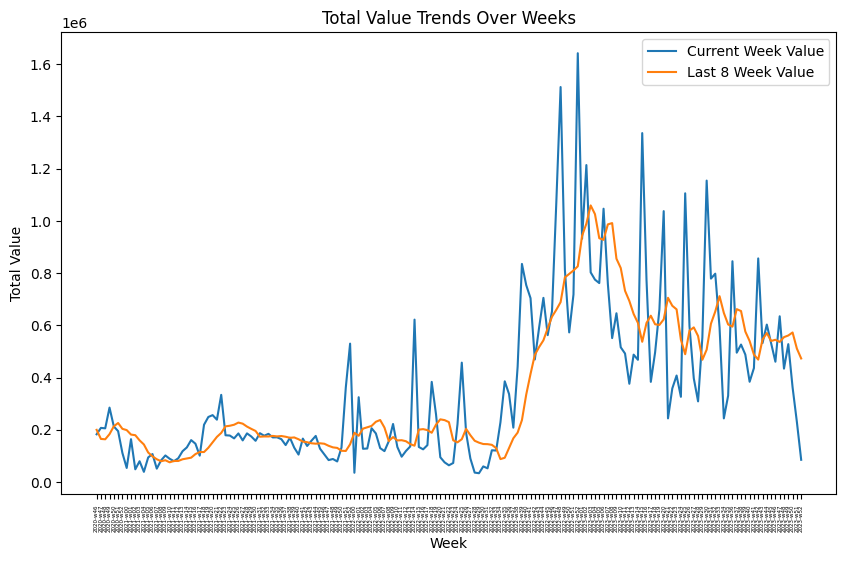

In [325]:
total_value_rows = merged_dataframe[merged_dataframe['Variables'] == 'Total_Value']
# Plot the graph
plt.figure(figsize=(10, 6))

# Plot 'WeekCount' versus 'Current Week Value'
plt.plot(total_value_rows['WeekCount'], total_value_rows['Current Week Value'], label='Current Week Value')

# Plot 'WeekCount' versus 'Last 8 Week Value'
plt.plot(total_value_rows['WeekCount'], total_value_rows['Last 8 Week Value'], label='Last 8 Week Value')

# Set labels and title
plt.xlabel('Week')
plt.ylabel('Total Value')
plt.title('Total Value Trends Over Weeks')
plt.xticks(rotation=90, fontsize=4)
plt.legend()

# Show the plot
plt.show()

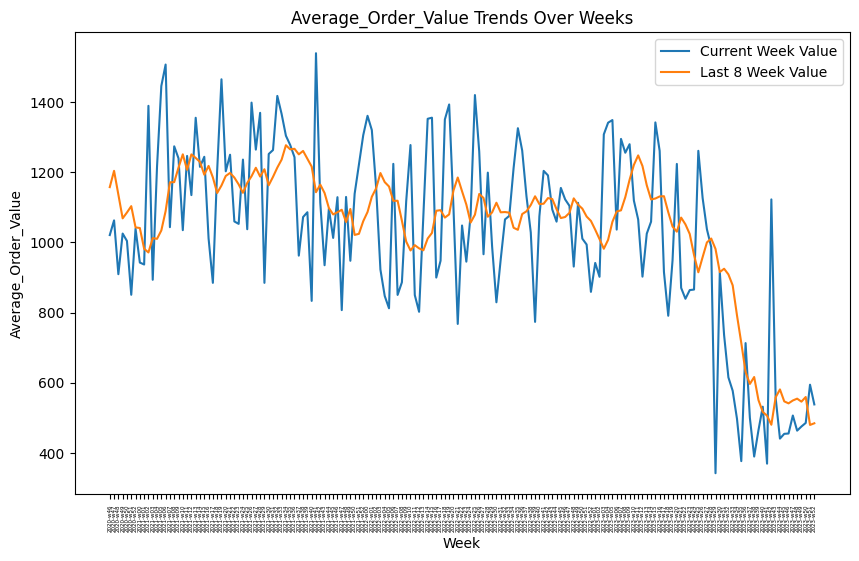

In [326]:
total_value_rows = merged_dataframe[merged_dataframe['Variables'] == 'Average_Order_Value']
# Plot the graph
plt.figure(figsize=(10, 6))

# Plot 'WeekCount' versus 'Current Week Value'
plt.plot(total_value_rows['WeekCount'], total_value_rows['Current Week Value'], label='Current Week Value')

# Plot 'WeekCount' versus 'Last 8 Week Value'
plt.plot(total_value_rows['WeekCount'], total_value_rows['Last 8 Week Value'], label='Last 8 Week Value')

# Set labels and title
plt.xlabel('Week')
plt.ylabel('Average_Order_Value')
plt.title('Average_Order_Value Trends Over Weeks')
plt.xticks(rotation=90, fontsize=4)
plt.legend()

# Show the plot
plt.show()

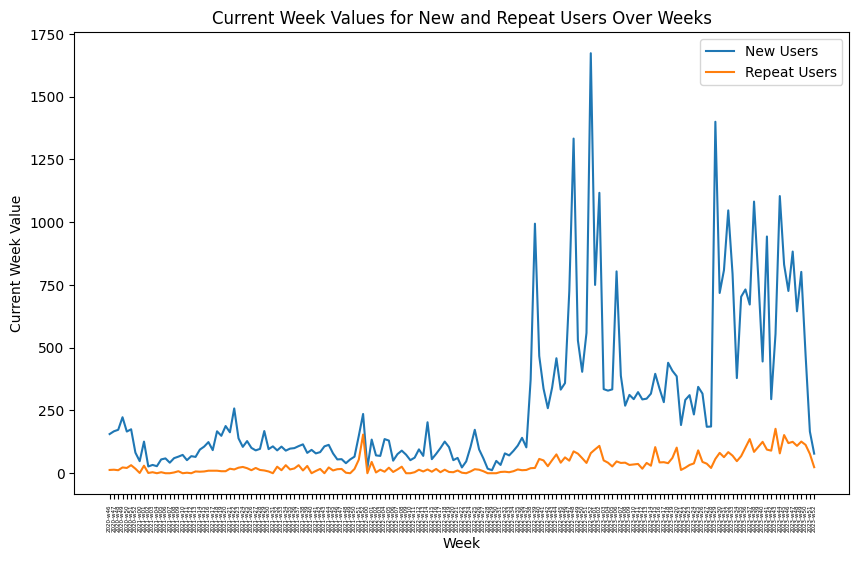

In [327]:
import matplotlib.pyplot as plt

# Filter for 'No_of_New_Users(First_Time_Users)'
new_users_rows = merged_dataframe[merged_dataframe['Variables'] == 'No_of_New_Users(First_Time_Users)']

# Filter for 'No_of_Repeat_Users'
repeat_users_rows = merged_dataframe[merged_dataframe['Variables'] == 'No_of_Repeat_Users']

# Plot the graph
plt.figure(figsize=(10, 6))

# Plot 'WeekCount' versus 'Current Week Value' for New Users
plt.plot(new_users_rows['WeekCount'], new_users_rows['Current Week Value'], label='New Users')

# Plot 'WeekCount' versus 'Current Week Value' for Repeat Users
plt.plot(repeat_users_rows['WeekCount'], repeat_users_rows['Current Week Value'], label='Repeat Users')

# Set labels and title
plt.xlabel('Week')
plt.ylabel('Current Week Value')
plt.title('Current Week Values for New and Repeat Users Over Weeks')
plt.xticks(rotation=90, fontsize=4)
plt.legend()

# Show the plot
plt.show()


In [328]:
# total_value_rows = merged_dataframe[merged_dataframe['Variables'] == 'No_of_Repeat_Users']
# # Plot the graph
# plt.figure(figsize=(10, 6))

# # Plot 'WeekCount' versus 'Current Week Value'
# plt.plot(total_value_rows['WeekCount'], total_value_rows['Current Week Value'], label='Current Week Value')

# # Plot 'WeekCount' versus 'Last 8 Week Value'
# plt.plot(total_value_rows['WeekCount'], total_value_rows['Last 8 Week Value'], label='Last 8 Week Value')

# # Set labels and title
# plt.xlabel('Week')
# plt.ylabel('No_of_Repeat_Users')
# plt.title('No_of_Repeat_Users Trends Over Weeks')
# plt.xticks(rotation=90, fontsize=4)
# plt.legend()

# # Show the plot
# plt.show()

In [329]:
new_df_1

,WeekCount,Variables,Current Week Value,Last 8 Week Value,Tag,User_Cohort_Labels,Product_Cohort_Labels
0,2020-w46,New Users<>Low Value & Slow Moving Products (Rs),2809.0,7587.625,Secondary_Explanatory,New Users,Low Value & Slow Moving Products
1,2020-w46,New Users<>High Value & Slow Moving Products (Rs),0.0,525.000,Secondary_Explanatory,New Users,High Value & Slow Moving Products
2,2020-w46,New Users<>High Repeat Products (Rs),4575.0,2206.750,Secondary_Explanatory,New Users,High Repeat Products
4,2020-w46,Champion Users<>Hero Products (Rs),4999.0,1832.000,Secondary_Explanatory,Champion Users,Hero Products
5,2020-w46,New Users<>New Business Products (Rs),136904.0,114544.875,Secondary_Explanatory,New Users,New Business Products
...,...,...,...,...,...,...,...
4940,2023-w52,Champion Users<>High Repeat Products (Rs),3510.0,2954.500,Secondary_Explanatory,Champion Users,High Repeat Products
4941,2023-w52,Champion Users<>Hero Products (Rs),23540.0,90714.875,Secondary_Explanatory,Champion Users,Hero Products
4946,2023-w52,Repeat Churned Users<>Low Value & Slow Moving ...,0.0,0.000,Secondary_Explanatory,Repeat Churned Users,Low Value & Slow Moving Products
4948,2023-w52,Churned Users<>Low Value & Slow Moving Product...,0.0,0.000,Secondary_Explanatory,Churned Users,Low Value & Slow Moving Products


In [330]:
# # Group the data by Product Cohort Labels
# grouped_data = new_df_1.groupby('Product_Cohort_Lables')

# # Plot the data for each Product Cohort Label
# plt.figure(figsize=(12, 8))

# for label, group in grouped_data:
#     plt.plot(group['WeekCount'], group['Current Week Value'], label=label)

# plt.xlabel('Week Count')
# plt.ylabel('Current Week Value')
# plt.title('Current Week Value for Each Product Cohort Label')
# plt.legend(title='Product Cohort Labels', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.show()

In [331]:
df_agg = new_df_1.groupby(['WeekCount', 'Product_Cohort_Lables'])['Current Week Value'].sum().reset_index()
pivot_df = df_agg.pivot(index='WeekCount', columns='Product_Cohort_Lables', values='Current Week Value')
ax = pivot_df.plot(kind='bar', stacked=True, figsize=(14, 6))
plt.title('Current Week Value vs Week Count for Product Cohort Lables')
plt.xlabel('Week Count')
plt.ylabel('Current Week Value')
ax.tick_params(axis='x', labelsize=4)
plt.show()

KeyError: ignored

In [332]:
df_agg_user = new_df_1.groupby(['WeekCount', 'User_Cohort_Lables'])['Current Week Value'].sum().reset_index()
pivot_df_user = df_agg_user.pivot(index='WeekCount', columns='User_Cohort_Lables', values='Current Week Value')
ax_user = pivot_df_user.plot(kind='bar', stacked=True, figsize=(14, 6))
plt.title('Current Week Value vs Week Count for User Cohort Lables')
plt.xlabel('Week Count')
plt.ylabel('Current Week Value')
ax_user.tick_params(axis='x', labelsize=4)
plt.show()

KeyError: ignored

In [263]:
# merged_dataframe['Variables'] = merged_dataframe.apply(lambda row: row['Variables'].replace('-', '<>') + f'({target_vars[0]})', axis=1)

In [264]:
merged_dataframe

,WeekCount,Variables,Current Week Value,Last 8 Week Value,Tag,Difference
0,2020-w46,New Users<>Low Value & Slow Moving Products(To...,2809.000000,7587.625000,Secondary_Explanatory,-4778.625000
1,2020-w46,New Users<>High Value & Slow Moving Products(T...,0.000000,525.000000,Secondary_Explanatory,-525.000000
2,2020-w46,New Users<>High Repeat Products(Total_Value)(T...,4575.000000,2206.750000,Secondary_Explanatory,2368.250000
3,2020-w46,Total_Orders(Total_Value)(Total_Value),179.000000,201.875000,Primary_Explanatory,-22.875000
4,2020-w46,Champion Users<>Hero Products(Total_Value)(Tot...,4999.000000,1832.000000,Secondary_Explanatory,3167.000000
...,...,...,...,...,...,...
4945,2023-w52,Total_Orders(Total_Value)(Total_Value),158.000000,998.250000,Primary_Explanatory,-840.250000
4946,2023-w52,Repeat Churned Users<>Low Value & Slow Moving ...,0.000000,0.000000,Secondary_Explanatory,0.000000
4947,2023-w52,Average_Order_Value(Total_Value)(Total_Value),538.139241,484.410204,NaN,53.729036
4948,2023-w52,Churned Users<>Low Value & Slow Moving Product...,0.000000,0.000000,Secondary_Explanatory,0.000000


In [145]:
averages_dict["2023-w52"].loc["Champions-Hero"]

KeyError: ignored

In [ ]:
grouped_dict["2023-w44"].loc["Champions-Hero"]